### Task: Build Simulation Orchestrator
* Create a rebase and non-rebasing token and simulate a series of N deposits

In [1]:
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
cwd =  os.getcwd().replace("notebooks/test","")
os.chdir(cwd)

from python.dev.simulation import SimulationOrchestrator
from python.dev.simulation import EventQueue
from python.dev.simulation import EventExecutor

from python.dev.agent import TokenAgent
from python.dev.agent import UserAgent

from python.dev.action import MintAction
from python.dev.event import Mint

from python.dev.simulation.batch import WithdrawBatch
from python.dev.simulation.batch import DepositBatch
from python.dev.simulation.batch import SwapBatch
from python.dev.simulation.batch.set import BatchSet

from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import TimeDeltaModel

from python.dev.lp import LiquidityPool
from python.dev.lp.event import LPEvent
from python.dev.lp.event import MintLPEvent
from python.dev.lp.event import DepositLPEvent
from python.dev.lp.event import SwapLPEvent

### Reproduce Task 104:
* Add graph of token balances for each holder

In [2]:
n_events = 100
apy = 0.123456
target1 = TokenAgent('T1')
target2 = TokenAgent('TCT')
user = UserAgent('sim_user')

In [3]:
mint_events1 = []
mint_events2 = []

for k in range(5):
    mint_events1.append(Mint(10000, 0.1234567, True)) 
    mint_events2.append(Mint(10000, 0.1234567, False))
    

In [4]:
deposit_batch1 = []
deposit_batch2 = []

for k in range(5):
    deposit_batch1.append(DepositBatch(target1, user, mint_events1[k]))   
    deposit_batch2.append(DepositBatch(target2, user, mint_events2[k]))
    

In [5]:
batch_set1 = BatchSet('batch_set_1', True)

for k in range(5):
    batch_set1.add_batch(deposit_batch1[k])   
    batch_set1.add_batch(deposit_batch2[k])
    
sim_batch1 = batch_set1.generate_events(apy, n_events)

======== Batch Set Tasks ===========
# name: batch_set_1
# num_repeats: 100 

[task 1] DEPOSIT_T1_BGP
[task 2] DEPOSIT_TCT_YVN
[task 3] DEPOSIT_T1_8IM
[task 4] DEPOSIT_TCT_4RG
[task 5] DEPOSIT_T1_30D
[task 6] DEPOSIT_TCT_85P
[task 7] DEPOSIT_T1_V6L
[task 8] DEPOSIT_TCT_J9F
[task 9] DEPOSIT_T1_ZGH
[task 10] DEPOSIT_TCT_KQ1



In [6]:
q = EventQueue()

for k in range(5):
    q.add_event(MintAction(mint_events1[k], target1, user))   
    q.add_event(MintAction(mint_events2[k], target2, user))
    
q.add_event_batch(sim_batch1)

In [7]:
lp = LiquidityPool('T1/TCT', user, target1, target2)

orchestrator = SimulationOrchestrator(verbose = False)
orchestrator.add_liquidity_pool('T1/TCT', lp)

executor = EventExecutor(q, orchestrator)
executor.run()

### Plot output


In [8]:
T1 = target1.get_token()
TCT1 = target2.get_token()

t1_addrs = []
tct_addrs = []

for k in range(5):
    t1_addrs.append(target1.get_address(mint_events1[k].get_id()))
    tct_addrs.append(target2.get_address(mint_events2[k].get_id()))
    

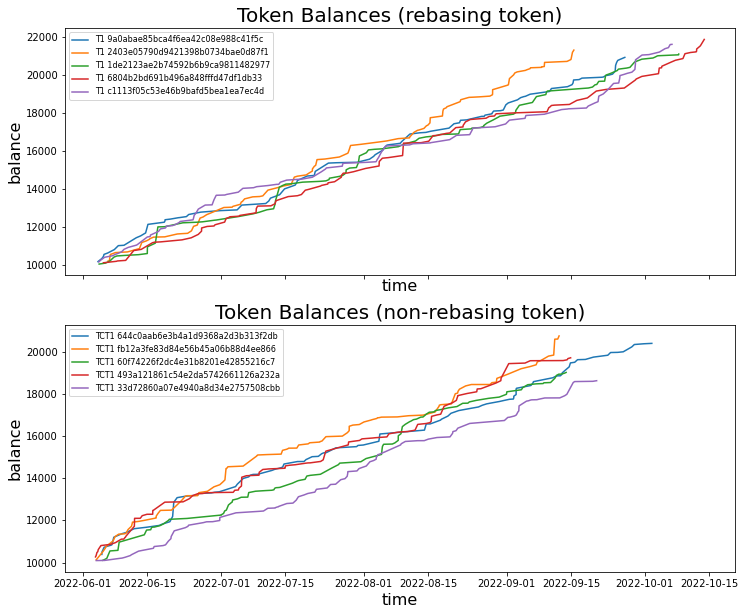

In [9]:
T_states = 5*[None]
final_balances = 5*[0]

fig, (T1_ax, TCT1_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

for m in range(5):
    T_states[m] = T1.get_state_series(t1_addrs[m])
    tSamp = T_states[m].get_tstamp() 
    balance = T_states[m].get_balance() 
    final_balances[m] = balance[-1]
    T1_ax.plot(tSamp, balance, label='T1 {}'.format(t1_addrs[m])) 

T1_ax.set_title("Token Balances (rebasing token)", fontsize=20)
T1_ax.set_ylabel("balance", fontsize=16)
T1_ax.set_xlabel('time', fontsize=16)
T1_ax.legend(fontsize=8)

for m in range(5):
    T_states[m] = TCT1.get_state_series(tct_addrs[m])
    tSamp = T_states[m].get_tstamp() 
    balance = T_states[m].get_balance() 
    final_balances[m] = balance[-1]
    TCT1_ax.plot(tSamp, balance, label='TCT1 {}'.format(tct_addrs[m])) 

TCT1_ax.set_title("Token Balances (non-rebasing token)", fontsize=20)
TCT1_ax.set_ylabel("balance", fontsize=16)
TCT1_ax.set_xlabel('time', fontsize=16)
TCT1_ax.legend(fontsize=8)
        

### Reproduce Task 105:
* Simulate CPT trading with a non-rebasing toke paired with a rebasing token

In [10]:
apy = 0.123456
T1_agent = TokenAgent('T1')
TCT1_agent = TokenAgent('TCT')
user = UserAgent('sim_user')

In [11]:
n_events = 100
token_deltas = TokenDeltaModel(1,100).apply(n_events) 
time_deltas = TimeDeltaModel().apply(n_events)

In [12]:
T1_mint = Mint(10000, apy, False)
TCT1_mint = Mint(10000, apy, True)

batch1 = DepositBatch(T1_agent, user, T1_mint)
batch2 = DepositBatch(TCT1_agent, user, TCT1_mint)
withdraw_sub_batch = WithdrawBatch(T1_agent, user, T1_mint)
deposit_sub_batch = DepositBatch(TCT1_agent, user, TCT1_mint)
batch3 = SwapBatch(withdraw_sub_batch, deposit_sub_batch)

batch1.set_token_deltas(token_deltas)
batch2.set_token_deltas(token_deltas)
batch3.set_token_deltas(token_deltas)

batch1.set_time_deltas(time_deltas)
batch2.set_time_deltas(time_deltas)
batch3.set_no_time_delay(True) 

In [13]:
batch_set1 = BatchSet('batch_set_1', True)
batch_set1.add_batch(batch1, 'deposit_t1', )
batch_set1.add_batch(batch2, 'deposit_tct1')
batch_set1.add_batch(batch3, 'swap_t1_tct1')

sim_batch1 = batch_set1.generate_events(apy, n_events)

======== Batch Set Tasks ===========
# name: batch_set_1
# num_repeats: 100 

[task 1] deposit_t1
[task 2] deposit_tct1
[task 3] swap_t1_tct1



In [14]:
q = EventQueue()
q.add_event(MintAction(T1_mint, T1_agent, user))
q.add_event(MintAction(TCT1_mint, TCT1_agent, user))
q.add_event_batch(sim_batch1)

In [15]:
lp = LiquidityPool('T1/TCT', user, T1_agent, TCT1_agent)

orchestrator = SimulationOrchestrator(verbose = False)
orchestrator.add_liquidity_pool('T1/TCT', lp)

executor = EventExecutor(q, orchestrator)
executor.run()

### Plot data

In [16]:
T1 = T1_agent.get_token()
TCT1 = TCT1_agent.get_token()

t1_addr = T1_agent.get_address(T1_mint.get_id())
tct_addr = TCT1_agent.get_address(TCT1_mint.get_id())

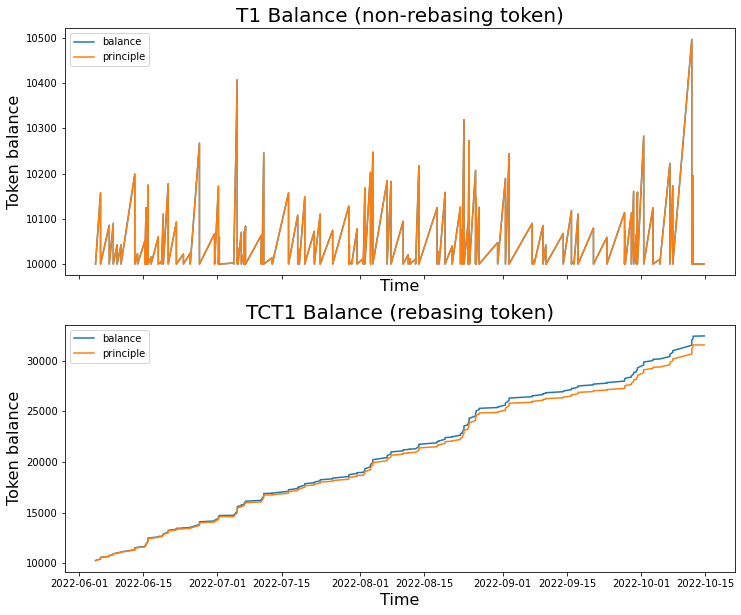

In [17]:
# Analyze Token balances

T1_states = T1.get_state_series(t1_addr)
principle = T1_states.get_principle() 
balance = T1_states.get_balance() 
tSamp = T1_states.get_tstamp()  

fig, (T1_ax, TCT1_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

T1_ax.plot(tSamp[1:], balance[1:], label='balance') 
T1_ax.plot(tSamp[1:], principle[1:], label='principle') 
T1_ax.set_title("T1 Balance (non-rebasing token)", fontsize=20)
T1_ax.set_ylabel("Token balance", fontsize=16)
T1_ax.set_xlabel('Time', fontsize=16)
T1_ax.legend()

TCT1_states = TCT1.get_state_series(tct_addr)
principle = TCT1_states.get_principle() 
balance = TCT1_states.get_balance() 
tSamp = TCT1_states.get_tstamp() 

TCT1_ax.plot(tSamp[1:], balance[1:], label='balance') 
TCT1_ax.plot(tSamp[1:], principle[1:], label='principle') 
TCT1_ax.set_title("TCT1 Balance (rebasing token)", fontsize=20)
TCT1_ax.set_ylabel("Token balance", fontsize=16)
TCT1_ax.set_xlabel('Time', fontsize=16)
TCT1_ax.legend()


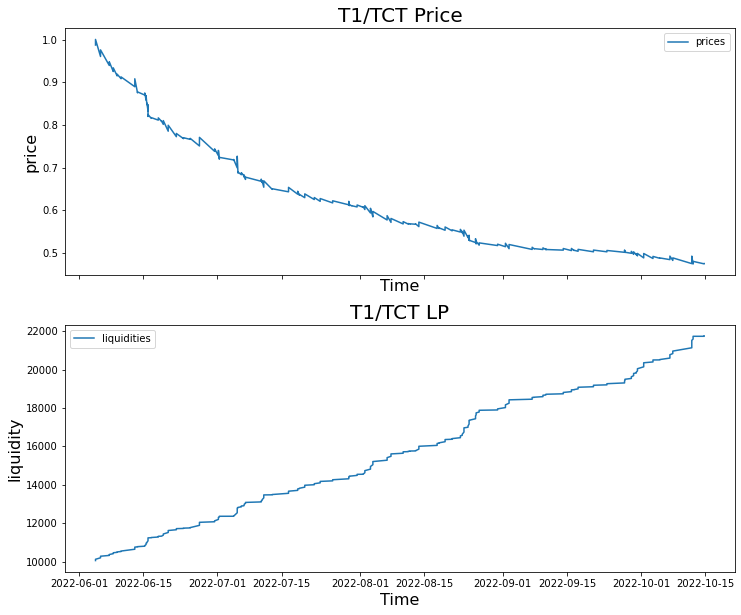

In [18]:
lp = orchestrator.get_liquidity_pool('T1/TCT')
tSamp = lp.get_lp_events().get_dates()
prices = lp.get_lp_events().get_prices()
liquidities = lp.get_lp_events().get_liquidity_values()

fig, (L_ax, P_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

L_ax.plot(tSamp[1:], prices[1:], label='prices') 
L_ax.set_title("T1/TCT Price", fontsize=20)
L_ax.set_ylabel("price", fontsize=16)
L_ax.set_xlabel('Time', fontsize=16)
L_ax.legend()

P_ax.plot(tSamp[1:], liquidities[1:], label='liquidities') 
P_ax.set_title("T1/TCT LP", fontsize=20)
P_ax.set_ylabel("liquidity", fontsize=16)
P_ax.set_xlabel('Time', fontsize=16)
P_ax.legend()
